#### Block 1 , test  and train Data for Object classification
#### set up environment ,  Upload raw data, preprocess pics 

In [1]:
# upload libraries to prepare data
import os
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.backend import clear_session

from random import sample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix # requires counts , integers , 1 or 0
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
def debug_photo( photo  ): #  to visualize pics
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        loc = np.random.randint(1, len(photo),1 )
        img= photo[loc[0]]  # 1 class pictures , sampled randomly
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
        

In [3]:
# https://chadrick-kwag.net/cv2-resize-interpolation-methods/

# set standard to image format

IMG_HEIGHT = 200
IMG_WIDTH = 200


def preprocess_image( x, h=IMG_HEIGHT , w=IMG_WIDTH, pad_value=30, color_scheme=cv2.COLOR_BGR2RGB, inter_method=cv2.INTER_CUBIC ): # cv2.INTER_AREA
    
        timage = cv2.cvtColor(x, color_scheme) 
        
        timage = cv2.copyMakeBorder(timage, pad_value, pad_value, pad_value, pad_value, 
                                           cv2.BORDER_CONSTANT, None, value=[255, 255, 255] ) 
        
        timage=cv2.resize(timage, (h, w), # make all pictures standard
                                 interpolation = inter_method)
        
        return timage
        

In [4]:

def accuracy_metrics(model ,  x_test , y_test , loop_count, sample_size ):

        for i in range(0,loop_count):

                loc = np.random.choice( x_test.shape[0], size = int( sample_size*x_test.shape[0]  ), replace=False, p=None)
                x_test_sample = x_test[loc]
                y_test_sample = y_test[loc]
                out = model.predict(x_test_sample)
                out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

                ac_metrics = {
                    "accuracy": [accuracy_score( y_test_sample , out_classes )], 
                    "precision":[precision_score( y_test_sample , out_classes, zero_division=0) ], 
                    "recall":[recall_score( y_test_sample , out_classes )]
                             }

                out_table = pd.DataFrame(ac_metrics,  index=[i])

                if i==0:   
                    result = out_table
                else:
                    result = pd.concat([result, out_table])
                    
        return result  

In [215]:
## delete generated files
## required if the code was updated and we need to refresh previously 
## generated images

buf1 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"
buf2 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class"
buf3 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"
buf4 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_1"
buf5 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_2"
buf6 = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\Test_Object_Detection_Synthetic\Augmented_3"

for i in [buf1, buf2, buf3, buf4, buf5, buf6] :
    for j in os.listdir( i ):
        file_delete = os.path.join(i, j)
        os.remove(file_delete)
    

In [2]:
## We preprocess data which forms both trainig and test pics,  later we would apply
## train_test_split method to generate 65 35 split, 

In [5]:
# location of pictures for train, validation and testing
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test"
folder_train

'D:\\0_Desctop_Files\\Learning\\UTM_Project\\1_Prototype\\1_Raw_Data_Train_Test'

In [276]:
os.listdir(folder_train) # debug

['apple_y_braeburn_1',
 'apple_y_crimson_snow_1',
 'apple_y_red_1',
 'apple_y_red_2',
 'apple_y_red_3',
 'apple_y_red_yellow_1',
 'Banana Lady Finger_1',
 'Banana Red_1',
 'Banana_1',
 'cabbage_white_1',
 'Cantaloupe_1',
 'Cocos_1',
 'forest_train_test',
 'Walnut_1',
 'Watermelon_1']

In [6]:
## import all pictures and generate labels to train model

img_data_array_0_class=[] # store pixels  of 0 class
img_data_array_1_class=[] # store pixels of target class


for dir1 in os.listdir(folder_train): # loop through folder in main directory
    for dir2 in os.listdir ( os.path.join(folder_train, dir1) ): # loop through jpg's in each folder
    
         if dir1 !="forest_train_test": # we skip forest_train_test, used later 
            
            image_path= os.path.join(folder_train, dir1,  dir2) # full path to file we need to upload

            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions

            image = preprocess_image(x = image)

              ## 1 class is stored separately as lated we need to augment pictures plus we add white padding
            if dir1.split("_")[1]=="y": # if folder with pictures contains "y" in name , then its 1, red apple, 0 otherwise
                         
                img_data_array_1_class.append(image) # append each picture to single structure              
                
            else: # pictures which belong to non apples ( other consumables , tasty and healthy )

                img_data_array_0_class.append(image) # append each picture to single structure
   

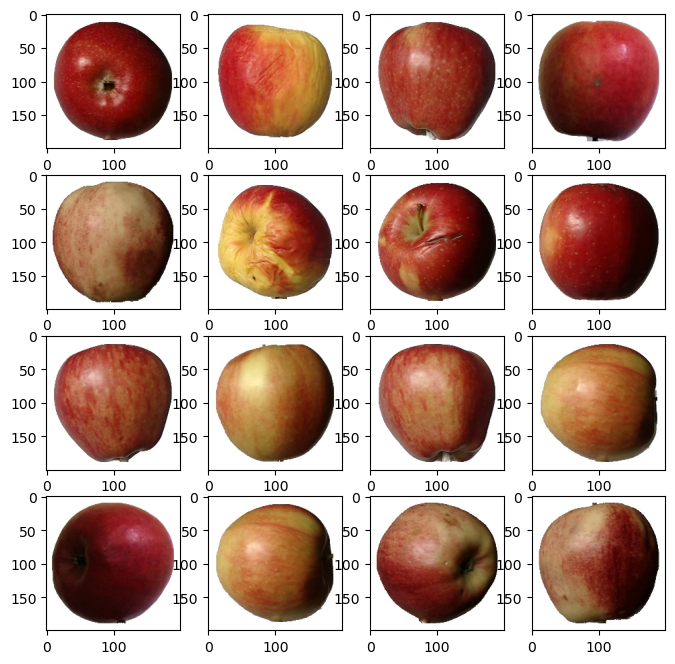

In [7]:
debug_photo( photo=img_data_array_1_class )     

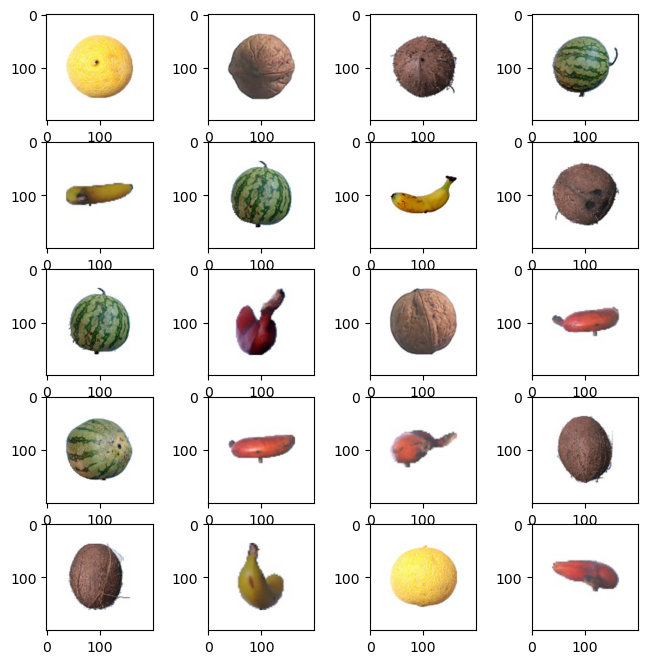

In [220]:
debug_photo( photo=img_data_array_0_class )    

In [91]:
########## Generate "picture blending" for backgroud
### We would train models with pictures with white background
### being unrealistic in real circumstances , we well as 
### generate synthetic ( augmented data ) to be as close as possible to 
### realistic diverse and representative input

In [221]:
## Uplaod pictures of nature scenery

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\forest_train_test"

img_data_array_backgroud=[] # store pixels 

for dir1 in os.listdir(folder_train): # loop through files in each folder
    
        image_path= os.path.join(folder_train, dir1)
        
        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
        
        image = preprocess_image(image, pad_value=0)
       
        img_data_array_backgroud.append(image) # append each picture to single structure
       

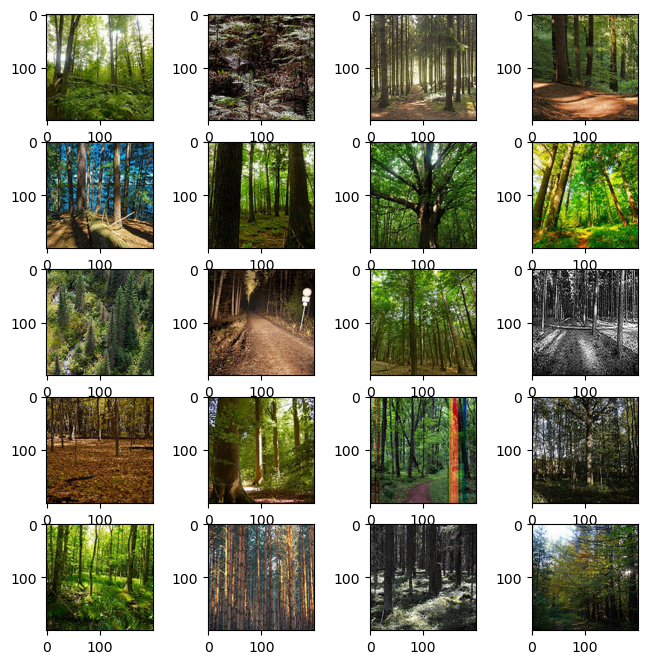

In [222]:
# debug
debug_photo( photo=img_data_array_backgroud )    

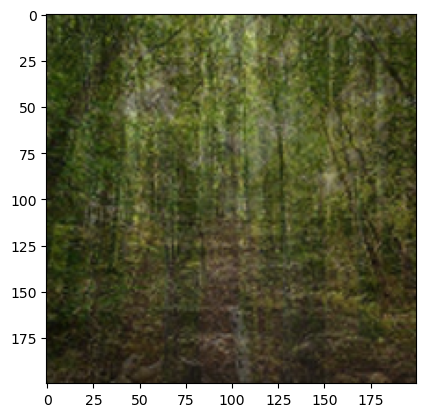

In [223]:
#### Sample of blended backgroupd
#### We generate picture which would replace
#### white backgound

loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
equal_fraction = 1 / 5
output = np.zeros_like( img_data_array_backgroud[0] )

list_images = [ img_data_array_backgroud[x] for x in loc ]

for img in list_images:
    output = output + img * equal_fraction
    
output = output.astype(np.uint8)    

plt.imshow(output)

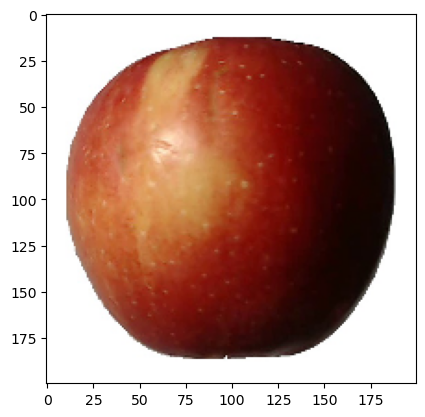

In [224]:
### verify preprocessing with 1 example
apple = img_data_array_1_class[0] 
plt.imshow( img_data_array_1_class[0] ) # debug

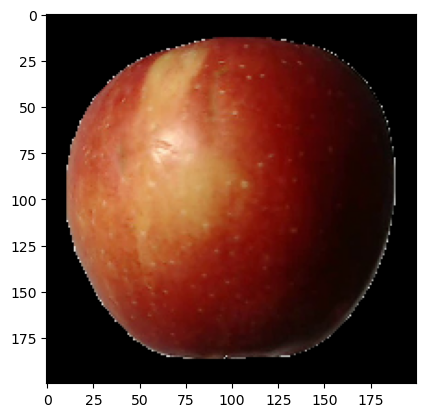

In [225]:
## each picture consist of 3 dimensions, Red , Blue and Green
## we create filter to assign  0 for each value within 3 dimensions
## which is over 230 ( white colour )

white_filter = (apple[:,:,0] > 220) & (apple[:,:,1] > 220) & (apple[:,:,2] > 220)

masked_image = np.copy(apple)
masked_image[white_filter != 0] = [0, 0, 0]
plt.imshow(masked_image)

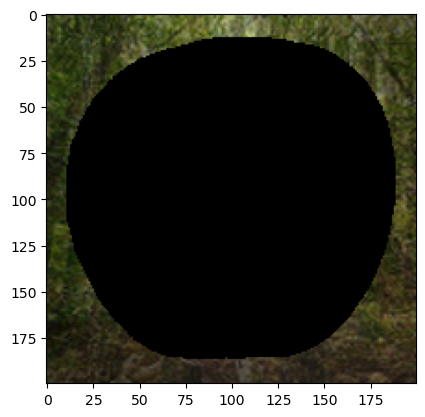

In [226]:
background_image = output.copy()
background_image[~(white_filter)] = [0,0,0]
plt.imshow(background_image)

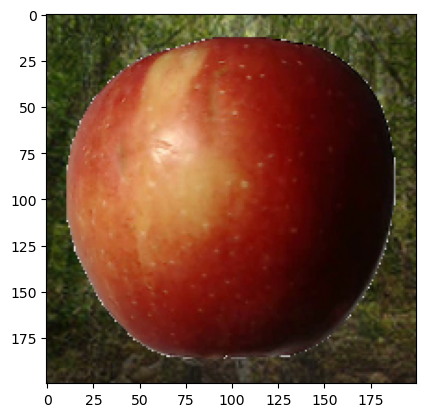

In [227]:
## replace white background
complete_image = masked_image + background_image
plt.imshow(complete_image)

In [228]:
####### Now  export 1 class pictures and store
###### pics with white and blended background 
###### We expect to train the model pattern in which 
###### background of object can be different while
###### the target area is characterised by presence of Red and Round Object

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"

for i in range( 0  ,  len(img_data_array_1_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
           # print( loc )  locations are random
            equal_fraction = 1 / 5
            background = np.zeros_like( img_data_array_backgroud[0] )
            
            list_images = [ img_data_array_backgroud[x] for x in loc ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            apple = img_data_array_1_class[i] 
            
            white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)
            
            masked_image = apple.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            
     ## form final image with new background and export it
    
            complete_image = masked_image + background
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )    
            cv2.imwrite(path_export_full, complete_image )
    
     ## export original picture with white background
    
            apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, apple )
            
            
y_count = len( img_data_array_1_class )  * 2          

In [229]:
[y_count , complete_image.shape]

[4982, (200, 200, 3)]

In [230]:
################ Now generate Train data for 0 class, 
## By cutting piece of picture and adding blended background 
# We slice the picture into 9 parts and randomly select 1 piece

height = int( IMG_HEIGHT / 3 ) # ( 3 * 3 = 9 pics )
width = int( IMG_WIDTH / 3 )
height,width # debug

(66, 66)

In [231]:
#### We would create coordinates for each piece out of 9 and would sample 
#### 1 sub pic from each downloaded picture of apple
x_start = np.arange( start = 0 , stop = IMG_HEIGHT -  width - 1 , step = width)
y_start = x_start.copy()

In [232]:
#### Reupload data and sample 1 sub image from each photo of target class
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"
# os.listdir( folder_train )

In [233]:
img_data_array_gen_pics=[] # store pixels 

for dir1 in os.listdir ( folder_train ):
         
        image_path= os.path.join(folder_train, dir1)

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
             
        image = preprocess_image(image, pad_value=0)
           
        ## set coordinates for sub pic (proposal)    
        random_coordinates = np.random.randint(low=0 , high=3, size = 2)
        loc_x = random_coordinates[0]
        loc_y = random_coordinates[1]

        timage =  image[ x_start[loc_x]:(x_start[loc_x]+width) , y_start[loc_y]:(y_start[loc_y]+height) ]
        
        timage = cv2.resize(timage, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                                 interpolation = cv2.INTER_AREA)
        # plt.imshow(buf_del )
               
        img_data_array_gen_pics.append(timage) # append each picture to single structure
 

In [234]:
len(img_data_array_gen_pics) == y_count     # debug

True

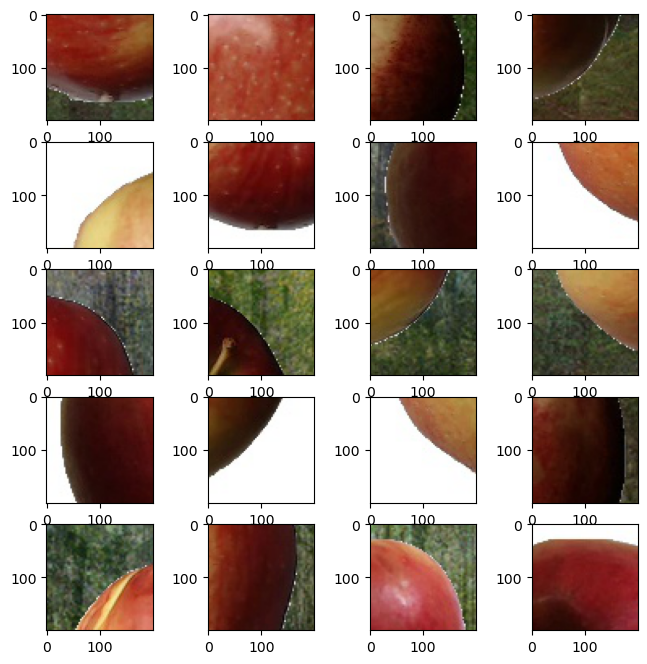

In [235]:
# debug
debug_photo( photo=img_data_array_gen_pics )    

In [236]:
########## Export Augmented photos treated as 0 class

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_gen_pics) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_gen_pics[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )

In [237]:
########## Export  0 class photos of Original size , with white and blended background

for i in range( 0  ,  len(img_data_array_0_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
           # print( loc )  locations are random
            equal_fraction = 1 / 5
            background = np.zeros_like( img_data_array_backgroud[0] )
            
            list_images = [ img_data_array_backgroud[x] for x in loc ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            other = img_data_array_0_class[i] 
            
            white_filter = (other[:,:,0] > 230) & (other[:,:,1] > 230) & (other[:,:,2] > 230)
            
            masked_image = other.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
    
    ## export 0 class with blended background
            complete_image = masked_image + background      
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_other"+str(i)+".jpg" )           
            cv2.imwrite(path_export_full, complete_image )
            
    ## export 0 class with original  white         
            other = cv2.cvtColor(other, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, other )
            
              

In [238]:
######### Export Non Augmented 0 class stored in img_data_array_backgroud

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_backgroud) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_backgroud[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_nature"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )

In [239]:
###  count of 1 class
y_count

4982

In [240]:
# count of 0 class
y0_count = len( os.listdir(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class") ) 

In [241]:
y0_count+=len(os.listdir(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"))

In [242]:
# check class balance , should be more than 20%
[ y_count, y0_count , y_count / (y_count + y0_count) ]

[4982, 12882, 0.278884908195253]

#### Import pictures of fruits or vegetables whose color and form is similar to 
#### color and form of class 1 (False Negatives)

In [243]:

folder_test_fn= r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class"

img_data_fn_array_0_class=[] # store pixels  of 0 class

for dir1 in os.listdir(folder_test_fn): # loop through folder in main directory
    for dir2 in os.listdir ( os.path.join(folder_test_fn, dir1) ): # loop through jpg's in each folder    
        
         if "Augmented" not in dir1: # we skip forest_train_test, used later 
            
            image_path= os.path.join(folder_test_fn, dir1,  dir2) # full path to file we need to upload
            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
            image = preprocess_image(image)
            img_data_fn_array_0_class.append(image) # append each picture to single structure
 

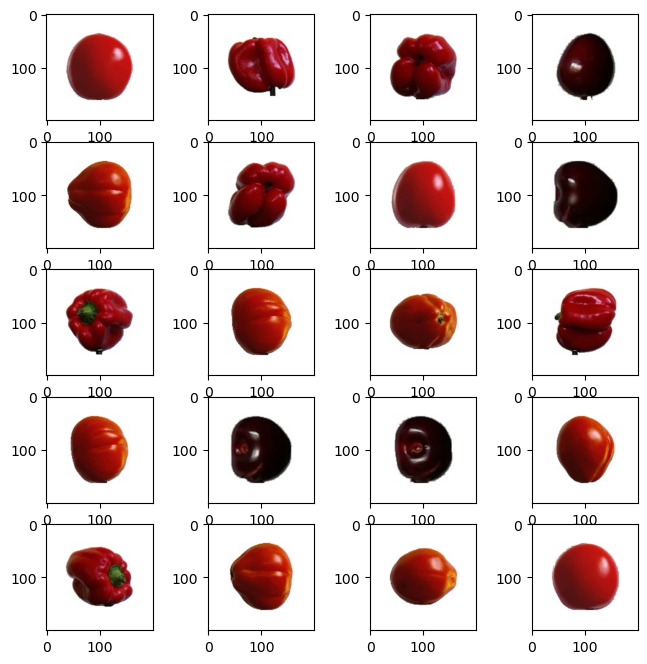

In [244]:
debug_photo( photo=img_data_fn_array_0_class )    

In [245]:
####### Export Augmented False Negatives
### Original and with adjusted background

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_1"

for i in range( 0  ,  len(img_data_fn_array_0_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
           # print( loc )  locations are random
            equal_fraction = 1 / 5
            background = np.zeros_like( img_data_array_backgroud[0] )
            
            list_images = [ img_data_array_backgroud[x] for x in loc ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            apple = img_data_fn_array_0_class[i] 
            
            white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)
            
            masked_image = apple.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            
     ## form final image with new background and export it
    
            complete_image = masked_image + background        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB           
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )    
            cv2.imwrite(path_export_full, complete_image )
    
     ## export original picture with white background
    
            apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, apple )
 

####  Generate pictures with color scheme identical to class 1 photo but of different shape

In [247]:
######### Estimate location of center
image_center = [ int(IMG_HEIGHT/2)  , int(IMG_WIDTH/2) ] 
image_center # considered as first element in 2 by 2 matrix

[100, 100]

In [248]:
#####  Verify process over a single picture
timg = img_data_array_1_class[2].copy()
#plt.imshow(timg)

In [249]:
x = image_center[0]
y = image_center[1]

In [250]:
timg[ (x-1):(x+1) , (y-1):(y+1)  ]

array([[[139,  26,  12],
        [139,  25,  14]],

       [[138,  25,  10],
        [138,  24,  13]]], dtype=uint8)

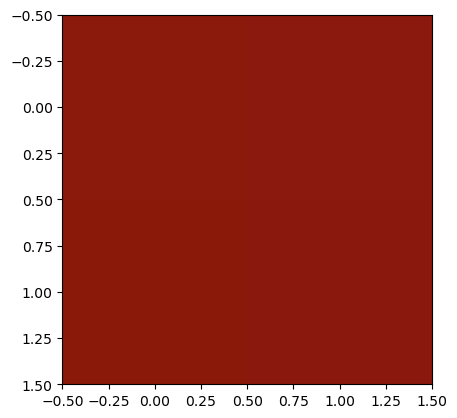

In [251]:
plt.imshow(  timg[ (x-1):(x+1) , (y-1):(y+1)  ]  )

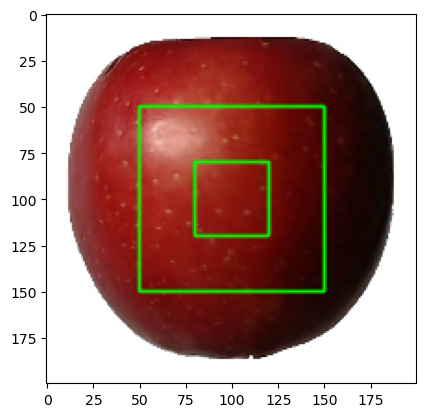

In [253]:
cv2.rectangle(timg, (x-50, y-50), (x+50, y+50), (0, 255, 0), 1, cv2.LINE_AA)
cv2.rectangle(timg, (x-20, y-20), (x+20, y+20), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow( timg )
timg = img_data_array_1_class[2].copy()

In [254]:
count = 0
step = 1

while count == 0 :
    buf = timg[ (x-step):(x+step) , (y-step):(y+step)  ]
   # print(buf)
   # if np.any(buf>230): # white points can be presented inside object, we need to check all 4 marginal points
    
    st_2 = 5 # forward look
    
    if np.all( timg[ x-step-st_2 , y-step-st_2 ] >230) & np.all( timg[ x+step+st_2 , y+step+st_2 ] >230) & np.all( timg[ x-step-st_2 , y+step+st_2 ] >230) & np.all( timg[ x+step+st_2 , y-step-st_2 ] >230):
        count = 1
    else:
         step+=1
step                       

65

In [255]:
buf = timg[ (x-step):(x+step) , (y-step):(y+step)  ]

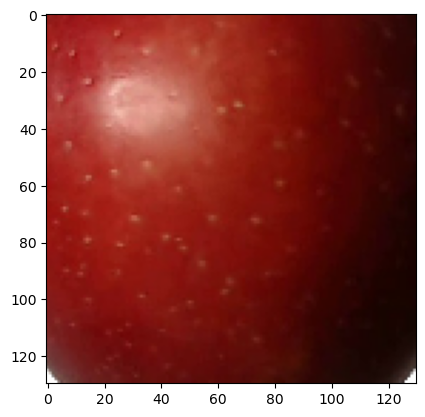

In [256]:
plt.imshow( buf ) ### all 4 must fit condition, thats why white padding can still be present

In [257]:
###### Repeat the process in the loop

####### Export Augmented False Negatives
### objects have identical to class 1 rgb profile , but different form

x = image_center[0]
y = image_center[1]

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_2"

for i in range( 0  ,  len(img_data_array_1_class) ) :  # len(img_data_array_1_class)
    
     ## sequentially process pictures with target
            timg = img_data_array_1_class[i].copy() 
            
            count = 0
            step = 1
            st_2 = 5
            
            while count == 0 :
                buf = timg[ (x-step):(x+step) , (y-step):(y+step)  ]

                if np.all( timg[ x-step-st_2 , y-step-st_2 ] >230) & np.all( timg[ x+step+st_2 , y+step+st_2 ] >230) & np.all( timg[ x-step-st_2 , y+step+st_2 ] >230) & np.all( timg[ x+step+st_2 , y-step-st_2 ] >230):
                    count = 1
                else:
                     step+=1
                        
            buf = preprocess_image(buf)              
    
            path_export_full = os.path.join ( path_export , "picture_dif_form"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, buf )
 

####  Visualise distribution of pixel values for greyscale images, for each apple
#### generate pandas data frame from numpy array
#### If certain type of apple is significantly different , we can exclude it as outlier

In [59]:
# https://www.geeksforgeeks.org/python-grayscaling-of-images-using-opencv/
# https://support.ptc.com/help/mathcad/r9.0/en/index.html#page/PTC_Mathcad_Help/example_grayscale_and_color_in_images.html
 # large greyscale values indicate that RGB source had large values within greyscale

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test"

img_data_array_numpy_to_pandas=[] # store pixels  of 0 class
apple_type=[]

for dir1 in os.listdir(folder_train): # loop through folder in main directory
    for dir2 in os.listdir ( os.path.join(folder_train, dir1) ): # loop through jpg's in each folder
              
        if dir1.split("_")[1]=="y": # if folder with pictures contains "y" in name , then its 1, red apple, 0 otherwise
                    
                image_path= os.path.join(folder_train, dir1,  dir2) # full path to file we need to upload

                image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
                
                image = preprocess_image(image ,  h=100 , w=100 , color_scheme=cv2.COLOR_BGR2GRAY) # to limit size of data frmae

                img_data_array_numpy_to_pandas.append(image) # append each picture to single structure
                
                apple_type.append( dir1 )

In [60]:
[ len( apple_type ) , len(img_data_array_numpy_to_pandas) ]

[2941, 2941]

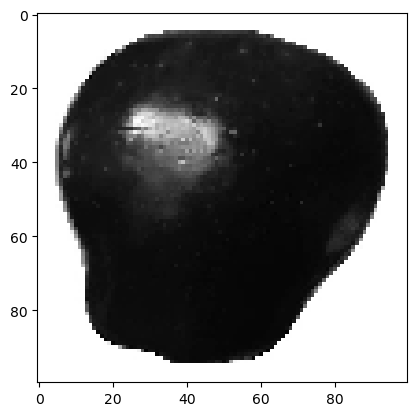

In [61]:
image= cv2.imread( r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\apple_y_red_delicios_1\r0_34.jpg", cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
image = preprocess_image(image ,  h=100 , w=100 , color_scheme=cv2.COLOR_BGR2GRAY) # to limit size of data frmae
plt.imshow( image , cmap="gray" )

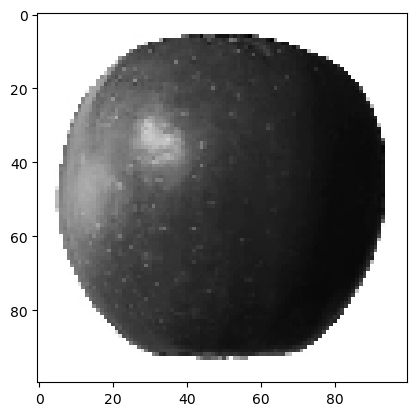

In [62]:
image= cv2.imread( r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\apple_y_braeburn_1\r0_34.jpg", cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
image = preprocess_image(image ,  h=100 , w=100 , color_scheme=cv2.COLOR_BGR2GRAY) # to limit size of data frmae
plt.imshow( image , cmap="gray" )

In [63]:
img_data_array_numpy_to_pandas = np.array( img_data_array_numpy_to_pandas, dtype = "int16" )

In [64]:
list_of_pixels = []
list_of_names = []

for i in range( 0 , len(img_data_array_numpy_to_pandas) ): 
    buf = img_data_array_numpy_to_pandas[i].copy()
    buf = buf.flatten().tolist()
    picture_names = [ apple_type[i] for x in range(0 , len(buf) ) ]
   # buf = [ x for x in buf if x<255 ] # its related to apple type list

    list_of_names.append( picture_names )
    list_of_pixels.append( buf )
    

In [65]:
[ len(list_of_pixels[0]) , len( list_of_pixels[0] )  ]

[10000, 10000]

In [66]:
[ len(list_of_pixels[10]) , len( list_of_pixels[10] )  ]

[10000, 10000]

In [67]:
flat_list_pixels = []
for sublist in list_of_pixels:
    for item in sublist:
        flat_list_pixels.append(item)        
len( flat_list_pixels )        

29410000

In [68]:
flat_list_names = []
for sublist in list_of_names:
    for item in sublist:
        flat_list_names.append(item)        
len( flat_list_names )       

29410000

In [69]:
### indices of values equal to 255
loc = []
for i in range(0, len(flat_list_pixels)):
    if flat_list_pixels[i] < 250:
        loc.append(i)
len(loc)        

18597399

In [70]:
flat_list_pixels = [flat_list_pixels[i] for i in loc]
flat_list_names = [flat_list_names[i] for i in loc]

In [71]:
[ len( flat_list_pixels ) , len(flat_list_names) ]

[18597399, 18597399]

In [72]:
# form dictionary

dict_buf = { "pixel_value":flat_list_pixels , 
             "apple_type":flat_list_names }
# dict_buf

In [73]:
import pandas as pd

df1 = pd.DataFrame.from_dict(dict_buf)
df1.head(5)


,pixel_value,apple_type
0,87,apple_y_braeburn_1
1,89,apple_y_braeburn_1
2,103,apple_y_braeburn_1
3,99,apple_y_braeburn_1
4,96,apple_y_braeburn_1


<AxesSubplot:xlabel='apple_type', ylabel='pixel_value'>

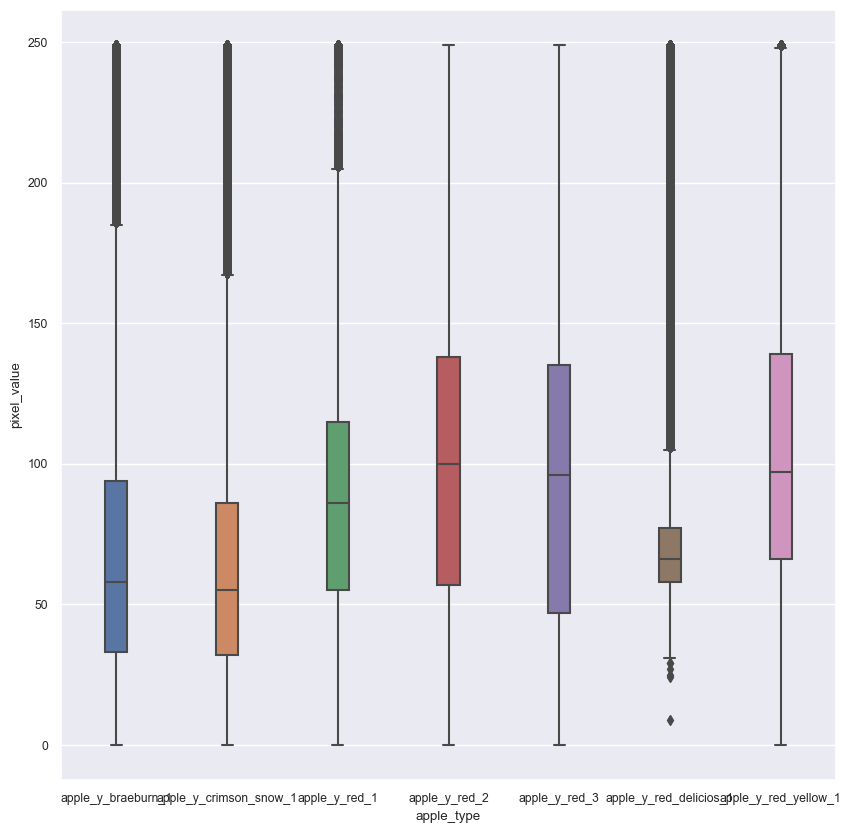

In [74]:
sns.set(rc={'figure.figsize':(10,10)}, font_scale=0.8)
#sns.set(font_scale=0.1)
sns.boxplot(data=df1, x="apple_type", y="pixel_value",  width=0.2)

## Photos of "red_delicies" are notably different from other apples types, specifically
## they contain multiple grey scale values in a range from 100 up to apr. 170
## It highlights that color scheme is notably darker compare to other apple's objects

#### Block 2 : Test Data for Object Detection
#### Generate pictures with multiple apples ( photos from  test and training )
#### Photos with white and mixed background
#### Initial photos are sampled randomly from folders with apples
#### File name contains number of apples on picture

In [281]:
# Script below generates photos containing multiple apples
# photos present on each picture are selected randomly

img_data_array_1_class_multiple_objects=[] # already used before

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\Test_Object_Detection_Synthetic\Augmented_3"

for image_count in range(0,20):

            i = np.random.randint(1,5,1)[0]
            for j in range(0, i+1):
                loc_image_1 = np.random.randint(0 , len(img_data_array_1_class) ,1)[0]
                loc_image_2 = np.random.randint(0 , len(img_data_array_1_class) ,1)[0]
                if j == 0:
                    im_v_1 = img_data_array_1_class[loc_image_1]
                    im_v_2 = img_data_array_1_class[loc_image_2]
                else:
                    im_v_1 = cv2.hconcat( [im_v_1 , img_data_array_1_class[loc_image_1]] )
                    im_v_2 = cv2.hconcat( [im_v_2 , img_data_array_1_class[loc_image_2]] )

            im_final = cv2.vconcat( [im_v_1 , im_v_2] )    
            im_final =  preprocess_image(x = im_final, h=500, w=500 , pad_value=10, color_scheme=cv2.COLOR_BGR2RGB) # cv2.COLOR_RGB2BGR
            
            ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
           # print( loc )  locations are random
            equal_fraction = 1 / 5
            background = np.zeros_like( img_data_array_backgroud[0] )
            
            list_images = [ img_data_array_backgroud[x] for x in loc ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
            background =  preprocess_image(x = background, h=500, w=500 , pad_value=0, color_scheme=cv2.COLOR_BGR2RGB) # cv2.COLOR_RGB2BGR
      
     ## sequentially process pictures with target
            apple_multiple = im_final.copy()
            
            white_filter = (apple_multiple[:,:,0] > 230) & (apple_multiple[:,:,1] > 230) & (apple_multiple[:,:,2] > 230)            
            masked_image = apple_multiple.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]           
            background[~(white_filter)] = [0,0,0]
            
     ## form final image with new background and export it
    
            complete_image = masked_image + background     
           # complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB          
            path_export_full = os.path.join ( path_export , "picture_"+str((i+1)*2)+"_multiple_proc_"+str(image_count)+".jpg" )    
            cv2.imwrite(path_export_full, complete_image )
                       
          #  img_data_array_1_class_multiple_objects.append( im_final )           
            path_export_full = os.path.join ( path_export , "picture_"+str((i+1)*2)+"_multiple_"+str(image_count)+".jpg" )      
            cv2.imwrite(path_export_full, im_final )
                                

#### Block 3, Pixel classification based on values in RGB Channel
#### We need to extract RGB profiles of pixels which belong to apples and non apples 
#### and train the model to predict if pixel belongs to apple
#### also, check quantile values of pixels of 0 and 1 classes
#### in order to identify appropriate threshhold

#### This is requred to improve accuracy of object count based on  cv2.findContours and cv2.Canny
#### specifically , if we blacken all pixels which dont belong to apple, we can count objects
#### with greater precision

In [5]:
### Upload images of apples , store pixels values in a list
### then mutate list to pandas frame

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test"
dir2 = [ x for x in os.listdir(folder_train) if  x.split("_")[1]=="y" ]

img_data_1_class_pixels=[] # store pixels  of 0 class
count_photos = 0
for i in dir2: 
        files_count = len( os.listdir ( os.path.join(folder_train, i ) ) ) # total number of files in folder
        loc = np.random.choice( files_count , size =  int(0.4*files_count) , replace=False, p=None) # indices for 30% of files in folder
        photos_list = os.listdir ( os.path.join(folder_train, i ) )    
        
        for j in loc:     
            # print( image_path )  # for debugging
            image_path= os.path.join(folder_train, i,  photos_list[j] )        
            image= cv2.imread( image_path, cv2.IMREAD_COLOR) 
            image = preprocess_image(x = image , h=100 , w=100, pad_value=0, inter_method=cv2.INTER_CUBIC  )
            count_photos+=1  
             
            # after image is uploaded we take all pixels from it and store it in List    
            for i2 in range(0 , image.shape[0] ):
                for j2 in range(0 , image.shape[0]  ):
                    buf = image[ i2 , j2 , :]   
                    img_data_1_class_pixels.append( buf )
                        
count_photos      

994

In [6]:
### Exclude white pixels , np.all requires array to use
img_data_list_class_pixels = [  x  for x in  img_data_1_class_pixels if (  np.all( x<=230 ) ) ] # ~(np.all( x>200 )) 

In [7]:
img_data_list_class_pixels[1:5]

[array([71, 15,  8], dtype=uint8),
 array([49,  8,  0], dtype=uint8),
 array([90, 56, 43], dtype=uint8),
 array([92, 60, 52], dtype=uint8)]

In [8]:
## generate frame from all pixels, long eta

df1_rgb_profile_apples = pd.DataFrame( img_data_list_class_pixels[0:], columns=["R","G","B"] )

df1_rgb_profile_apples.head(5)


,R,G,B
0,70,46,40
1,71,15,8
2,49,8,0
3,90,56,43
4,92,60,52


In [9]:
df1_rgb_profile_apples.shape # debug

(7875394, 3)

In [10]:
df1_rgb_profile_apples.describe() # summary statistics

,R,G,B
count,7.875394e+06,7.875394e+06,7.875394e+06
mean,1.315832e+02,6.465437e+01,4.260536e+01
std,5.361810e+01,4.889309e+01,3.442343e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+01,2.200000e+01,1.500000e+01
50%,1.400000e+02,5.300000e+01,3.300000e+01
75%,1.740000e+02,1.010000e+02,6.400000e+01
max,2.300000e+02,2.300000e+02,2.300000e+02


In [11]:
np.quantile( df1_rgb_profile_apples["R"] , np.array( [0.1 , 0.25 , 0.5 , 0.75 , 0.9] ) ) 

array([ 51.,  90., 140., 174., 198.])

In [12]:
np.quantile( df1_rgb_profile_apples["G"] , np.array( [0.1 , 0.25 , 0.5 , 0.75 , 0.9] ) ) 

array([ 10.,  22.,  53., 101., 139.])

In [13]:
np.quantile( df1_rgb_profile_apples["B"] , np.array( [0.1 , 0.25 , 0.5 , 0.75 , 0.9] ) ) 

array([ 7., 15., 33., 64., 92.])

In [14]:
del img_data_1_class_pixels

In [17]:
######### We need to extract RGB scheme of picture 
### Upload images of non apples 

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\forest_train_test"

img_data_0_class_pixels=[] # store pixels  of 0 class
photos_list = os.listdir(folder_train)
loc = np.random.choice( len(photos_list) , size =  int( 0.8 * len(photos_list) ) , replace=False, p=None)

for i in loc: 
                image_path= os.path.join(folder_train,  photos_list[i] ) 
                image= cv2.imread( image_path, cv2.IMREAD_COLOR) 
                image = preprocess_image(x = image ,  h=100 , w=100, pad_value=0)
                
                # after image is uploaded we take all pixels from it and store it in List    
                for i in range(0 , image.shape[0] ):
                    for j in range(0 , image.shape[0]  ):
                        buf = image[ i , j , :]   # if np.all( buf<240 ):
                        img_data_0_class_pixels.append( buf )

len( loc )                        

800

In [18]:
### Exclude white pixels , np.all requires array to use
img_data_list_0_class_pixels = [  x  for x in  img_data_0_class_pixels if  (  np.all( x<=230 ) ) ]# ~(np.all( x>200 )) , (np.all( x<200 )) 

In [19]:
img_data_list_0_class_pixels[1:5]

[array([42, 42, 42], dtype=uint8),
 array([44, 44, 44], dtype=uint8),
 array([35, 35, 35], dtype=uint8),
 array([77, 77, 77], dtype=uint8)]

In [20]:
## generate frame from all pixels, long eta

df1_rgb_profile_non_apples = pd.DataFrame( img_data_list_0_class_pixels[0:], columns=["R","G","B"] )

df1_rgb_profile_non_apples.head(5)


,R,G,B
0,14,14,14
1,42,42,42
2,44,44,44
3,35,35,35
4,77,77,77


In [21]:
df1_rgb_profile_non_apples.shape # debug

(7759743, 3)

In [22]:
df1_rgb_profile_non_apples.describe() # summary statistics

,R,G,B
count,7.759743e+06,7.759743e+06,7.759743e+06
mean,7.900048e+01,8.598129e+01,5.743067e+01
std,5.293348e+01,5.409652e+01,4.998651e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.700000e+01,4.300000e+01,1.800000e+01
50%,7.000000e+01,7.800000e+01,4.400000e+01
75%,1.130000e+02,1.230000e+02,8.400000e+01
max,2.300000e+02,2.300000e+02,2.300000e+02


In [23]:
del img_data_0_class_pixels

In [24]:
#### Generate  y labels

y_1 =  np.ones( len(df1_rgb_profile_apples) ) #target class
y_2 =  np.zeros( len(df1_rgb_profile_non_apples) )

y_train_test = np.append( y_1 , y_2 )

In [25]:
#### Generate array with training and test data with all classes

x_train_test = pd.concat([df1_rgb_profile_apples, df1_rgb_profile_non_apples])
[ x_train_test.shape , y_train_test.shape ]


In [27]:
# to use keras we need to transform pandas frame to array
x_train_test = np.array( x_train_test, dtype = "float16" )
x_train_test_buf = x_train_test / 255 # for 3 features for which max is 255

In [28]:
del df1_rgb_profile_apples , df1_rgb_profile_non_apples

In [29]:

#### train data  + remainder data ( validation and test )
x_train, x_rem, y_train, y_rem =  train_test_split( x_train_test_buf ,  y_train_test , test_size = 0.35 , shuffle=True, stratify =  y_train_test)
  # dont confuse training and test size
    
#### remainder data split to validation and test
x_valid, x_test, y_valid, y_test = train_test_split(x_rem , y_rem , test_size=0.5,  shuffle=True, stratify =  y_rem)


In [30]:
# debug
print(x_train.shape), print(y_train.shape) # is the largest
print(x_valid.shape), print(y_valid.shape) # valid and test are the same
print(x_test.shape), print(y_test.shape)

 # debug, check class balance
[ sum(y_train) / y_train.shape[0] , sum(y_valid) / y_valid.shape[0]   , sum(y_test) / y_test.shape[0]    ] 


(10162839, 3)
(10162839,)
(2736149, 3)
(2736149,)
(2736149, 3)
(2736149,)


[0.5036984252136633, 0.5036984462468966, 0.5036984462468966]

In [45]:
# delete model if exists
try:
    del model
except:
    print("not generated")

not generated


In [46]:
# First model to classify pixel based on 3 inputs

model = Sequential()

model.add( Dense( 5, input_shape=(x_train.shape[1] , ), activation="relu" ) )
model.add( Dense( 3,  activation="relu" ) )
model.add( Dense(1, activation="sigmoid") )

# compile the keras model
opt = Adam(learning_rate=0.001) # usually its 0.001

model.compile(optimizer=opt, 
             loss=binary_crossentropy, # prob of 1 class
             metrics=['accuracy'])


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [48]:

history = model.fit(x_train, y_train, 
                    epochs=5, 
                    batch_size=52 , # number of observations allows larger batch size, for 32, 52, 200 , accuracy is apr. 94% on validation
                    validation_data =  (x_valid , y_valid) 
                   )


Epoch 1/5
195440/195440 [==============================] - 451s 2ms/step - loss: 0.1718 - accuracy: 0.9346 - val_loss: 0.1663 - val_accuracy: 0.9351
Epoch 2/5
195440/195440 [==============================] - 453s 2ms/step - loss: 0.1649 - accuracy: 0.9370 - val_loss: 0.1643 - val_accuracy: 0.9369
Epoch 3/5
195440/195440 [==============================] - 452s 2ms/step - loss: 0.1642 - accuracy: 0.9371 - val_loss: 0.1648 - val_accuracy: 0.9357
Epoch 4/5
195440/195440 [==============================] - 452s 2ms/step - loss: 0.1637 - accuracy: 0.9374 - val_loss: 0.1629 - val_accuracy: 0.9380
Epoch 5/5
195440/195440 [==============================] - 454s 2ms/step - loss: 0.1628 - accuracy: 0.9378 - val_loss: 0.1595 - val_accuracy: 0.9382


In [50]:

#model.save(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_rgb_detect.keras")
model_v0_rgb_detect = load_model(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_rgb_detect.keras")
 

85505/85505 [==============================] - 114s 1ms/step


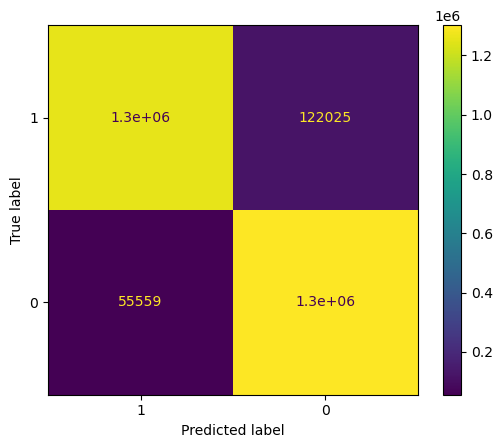

In [51]:
## Generate forecast with test data

out = model_v0_rgb_detect.predict( x_test ) 
out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

cm = confusion_matrix(y_test, out_classes, labels=np.array( [1,0] ))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.array( [1,0] ) )
disp.plot()
plt.show()


In [52]:
accuracy_metrics( model = model_v0_rgb_detect, x_test =  x_train_test_buf , y_test = y_train_test , loop_count=5, sample_size=0.3)    

146580/146580 [==============================] - 197s 1ms/step


,accuracy,precision,recall
0,0.935200,0.957716,0.911568
1,0.935183,0.957717,0.911520
2,0.935265,0.957890,0.911588
3,0.935090,0.957645,0.911531
4,0.935223,0.957761,0.911687


In [49]:
# Second model to classify pixel based on 3 inputs + Polynomial features

### Train model with Polynomial features

poly = PolynomialFeatures( 2 , include_bias = False)
x_train_test_transform = poly.fit_transform(x_train_test.copy())

[ x_train_test_transform.shape , x_train_test_transform[0] ]


[(12802881, 9),
 array([  94.,   86.,   84., 8832., 8084., 7896., 7396., 7224., 7056.],
       dtype=float16)]

In [50]:

#### train data  + remainder data ( validation and test )
x_train, x_rem, y_train, y_rem =  train_test_split( x_train_test_transform ,  y_train_test , test_size = 0.35 , shuffle=True, stratify =  y_train_test)
  # dont confuse training and test size
    
#### remainder data split to validation and test
x_valid, x_test, y_valid, y_test = train_test_split(x_rem , y_rem , test_size=0.5,  shuffle=True, stratify =  y_rem)


In [63]:
# debug
print(x_train.shape), print(y_train.shape) # is the largest
print(x_valid.shape), print(y_valid.shape) # valid and test are the same
print(x_test.shape), print(y_test.shape)

[ sum(y_train) / y_train.shape[0] , sum(y_valid) / y_valid.shape[0]   , sum(y_test) / y_test.shape[0]    ] 

(8321872, 9)
(8321872,)
(2240504, 9)
(2240504,)
(2240505, 9)
(2240505,)


[0.4685105706985159, 0.468510656530852, 0.46851044742145187]

In [68]:
# delete model if exists
try:
    del model
except:
    print("not generated")

not generated


In [57]:
clear_session() 

In [69]:

model = Sequential()

model.add( Dense( 11, input_shape=(x_train.shape[1] , ), activation="relu" ) )
model.add( Dense( 6, activation="relu" ) )
model.add( Dense( 3, activation="relu" ) )
model.add( Dense(1, activation="sigmoid") )

# compile the keras model
opt = Adam(learning_rate=0.001) # usually its 0.001

model.compile(optimizer=opt, 
             loss=binary_crossentropy, # prob of 1 class
             metrics=['accuracy'])


In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                110       
                                                                 
 dense_1 (Dense)             (None, 6)                 72        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [71]:

history = model.fit(x_train, y_train, 
                    epochs=5, 
                    batch_size=52 , 
                    validation_data =  (x_valid , y_valid) )


Epoch 1/5
160036/160036 [==============================] - 383s 2ms/step - loss: 1.2173 - accuracy: 0.9295 - val_loss: 0.1565 - val_accuracy: 0.9376
Epoch 2/5
160036/160036 [==============================] - 381s 2ms/step - loss: 0.1490 - accuracy: 0.9437 - val_loss: 0.1455 - val_accuracy: 0.9444
Epoch 3/5
160036/160036 [==============================] - 376s 2ms/step - loss: 0.1441 - accuracy: 0.9449 - val_loss: 0.1411 - val_accuracy: 0.9455
Epoch 4/5
160036/160036 [==============================] - 384s 2ms/step - loss: 0.1434 - accuracy: 0.9452 - val_loss: 0.1420 - val_accuracy: 0.9459
Epoch 5/5
160036/160036 [==============================] - 469s 3ms/step - loss: 0.1430 - accuracy: 0.9453 - val_loss: 0.1435 - val_accuracy: 0.9449


In [5]:

model.save(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v1_rgb_detect.keras")
model_v1_rgb_detect = load_model(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v1_rgb_detect.keras")
 

70016/70016 [==============================] - 105s 1ms/step


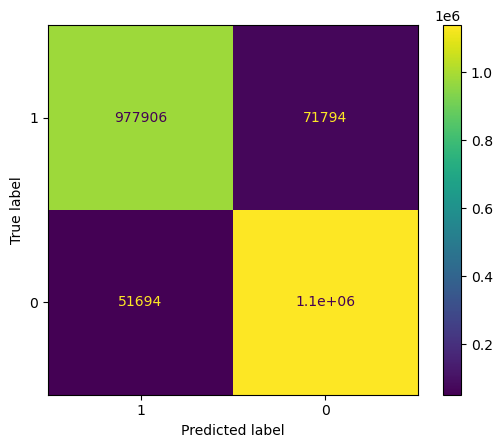

In [77]:
## Generate forecast with test data
out = model_v1_rgb_detect.predict( x_test ) 
out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

cm = confusion_matrix(y_test, out_classes, labels=np.array( [1,0] ))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.array( [1,0] ) )
disp.plot()
plt.show()


In [78]:
accuracy_metrics( model = model_v1_rgb_detect, x_test =  x_train_test_transform , y_test = y_train_test , loop_count=5, sample_size=0.3)    

120027/120027 [==============================] - 222s 2ms/step


,accuracy,precision,recall
0,0.945024,0.949966,0.931779
1,0.944908,0.950064,0.931382
2,0.945018,0.950049,0.931632
3,0.945025,0.950018,0.931729
4,0.944885,0.950030,0.931379


In [53]:
### Genarate grid of all possible combinations of RBG values and 
### augment with polynomial features (if required)

colR= pd.DataFrame( {"R":range(51,231) } )  # based on q1 quantiles for target class pixels
colG= pd.DataFrame( {"G":range(10,231) } )
colB= pd.DataFrame( {"B":range(7,231) } )    

part_1 = pd.merge(colR.assign(key=1), colG.assign(key=1),  # colR.assign(key=1) adds 1 coluns of one-s
                 on='key').drop('key', axis=1)

part_2 = pd.merge(part_1.assign(key=1), colB.assign(key=1), 
                 on='key').drop('key', axis=1)

part_2.head(5)   

,R,G,B
0,51,10,7
1,51,10,8
2,51,10,9
3,51,10,10
4,51,10,11


In [54]:
#### how many duplicates are present, should be 0
part_2.duplicated().sum()

0

In [56]:
### Add polynomial features

# poly = PolynomialFeatures( 2 , include_bias = False)
# rgb_dict = poly.fit_transform( rgb_dict )

rgb_dict  = np.array( part_2.copy(), dtype = "int16" )
rgb_dict[0:5]


array([[51, 10,  7],
       [51, 10,  8],
       [51, 10,  9],
       [51, 10, 10],
       [51, 10, 11]], dtype=int16)

In [57]:
rgb_dict.shape

(8910720, 3)

In [58]:
## generate data frame 
## features columns are not required for mapping , because sequence of 
## first 3 columns does not have duplicates

rgb_frame = pd.DataFrame( rgb_dict, columns=["R","G","B"] ) # order should be same as for values in list
#rgb_frame = pd.DataFrame( rgb_dict, columns=["R","G","B","f1","f2","f3","f4","f5","f6"] ) # order should be same as for values in list
rgb_frame.head(5)

,R,G,B
0,51,10,7
1,51,10,8
2,51,10,9
3,51,10,10
4,51,10,11


In [59]:
rgb_frame.shape

(8910720, 3)

In [60]:
## Generate forecast 

out = model_v0_rgb_detect.predict( rgb_dict ) 


278460/278460 [==============================] - 369s 1ms/step


In [61]:
np.unique( out )[1:5] # should represent probabilities

array([1.1766213e-38, 1.1787957e-38, 1.1789846e-38, 1.1793984e-38],
      dtype=float32)

In [62]:
out_classes = ( out > 0.2 ) + 0 # to whole numbers 
np.unique(out_classes)

array([0, 1])

In [63]:
del rgb_dict
del part_2

In [ ]:
# slow solution to add column 
# out_list = out.tolist()
# flat_out_list = sum( out_list, [] ) # flatten list, only for list of lists
 # https://www.makeuseof.com/python-nested-list-flatten/
    

In [64]:
## add column with classification result
rgb_frame["class_val"] = out_classes
rgb_frame["class_val"][0:5]

0    1
1    1
2    1
3    1
4    1
Name: class_val, dtype: int32

In [127]:
## DEBUG: could be that assigning out to column automatically changes data type
# https://saturncloud.io/blog/why-is-python-pandas-dataframe-rounding-my-values/#:~:text=The%20issue%20of%20Pandas%20DataFrame,values%20to%20two%20decimal%20places.
# Pandas rounds number, therefore generate class before adding probs to data frame

#rgb_frame["test"] = out
#buf = rgb_frame["test"][0:5]
#del rgb_frame["test"]
#buf.tolist()
## !! predictions are rounded which causes class mismatch

[1.0, 1.0, 1.0, 1.0, 1.0]

In [106]:
## transform propabilities to classes, excluded , as pandas rounds probabilities to 2 decimals
#out_classes = [ 0 if x<=0.2 else 1 for x in rgb_frame["class_val"].tolist() ]    
#rgb_frame["class_val"] = out_classes

In [70]:
rgb_frame.head(5)

,R,G,B,class_val
0,51,10,7,1
1,51,10,8,1
2,51,10,9,1
3,51,10,10,1
4,51,10,11,1


In [71]:
## column with rgb profiles as string
rgb_profile_list=[]
for i in range(0 , rgb_frame.shape[0]):
    rgb_profile_list.append( str(rgb_frame["R"][i]) + "_" + str(rgb_frame["G"][i])  + "_" + str(rgb_frame["B"][i] ) )

In [72]:
rgb_profile_list[1:5]

['51_10_8', '51_10_9', '51_10_10', '51_10_11']

In [73]:
# add column to data frame
rgb_frame["rgb_profile"] = rgb_profile_list

In [79]:
rgb_frame.head( 5 )

,R,G,B,class_val,rgb_profile
0,51,10,7,1,51_10_7
1,51,10,8,1,51_10_8
2,51,10,9,1,51_10_9
3,51,10,10,1,51_10_10
4,51,10,11,1,51_10_11


In [80]:
rgb_frame.shape

(8910720, 5)

In [81]:
rgb_frame.dtypes

R               int16
G               int16
B               int16
class_val       int32
rgb_profile    object
dtype: object

In [28]:
## drop features columns, can be done earlier
# rgb_frame = rgb_frame.astype(int)
# rgb_frame = rgb_frame[["R","G","B","class_val"]]

In [82]:
rgb_frame.to_csv( r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\rgb_mapping.txt", index = False ) 